## AI for finance [IE471 / IE 412]

#### Hands-on Practice on Session #4
#### [Session 4] Deep Hedging
##### Main assistant for this Session: Chan yeong Kim, E-mail: kim.chanyeong@kaist.ac.kr

0. Utils
1. Define Derivatives
2. Define a function for profit and loss
3. Create hedging model
4. Compute profit and loss before training
5. Train hedging model
6. Compute profit and loss after training
7. Compare profit and loss before/after training
[Assignment]
8. Train hedging model using PnL as objective [HW]
9. Plot PnL after training with PnL
10. Compare the training results

In [ ]:
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import torch
import torch.nn.functional as F

from torch import nn as nn
from torch.distributions.normal import Normal
from tqdm import tqdm

In [ ]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

# **Hedging a short at-the-money 30-days European call option**

#*Utils*

In [ ]:
def entropic_loss(pnl, a=0.5):
    """
    Return entropic loss function

    :param pnl: Profit and loss distribution - torch.Tensor
    :return: entropic loss - torch.Tensor
    """

    return torch.log(torch.mean(torch.exp(-a * pnl))) / a

In [ ]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# *1. Define derivatives*

In [ ]:
def generate_geometric_brownian_motion(n_paths, maturity=30 / 365, dt=1 / 365, volatility=0.2, device='cpu'):
    """
    Generate Monte Carlo Paths for Geometric Brownian Motion.
    Assume risk-free interest rate = 0

    :param n_paths: Number of price paths - int
    :param maturity: Length of simulated period - float
    :param dt: Interval of time steps - float
    :param volatility: Volatility of asset price - float
    :return: Paths of Geometric Brownian Motion - torch.Tensor
    """

    randn = torch.randn((int(maturity / dt), n_paths), device=device)
    randn[0, :] = 0.0

    bm = volatility * (dt ** 0.5) * randn.cumsum(0)
    t = torch.linspace(0, maturity, int(maturity / dt)).unsqueeze(1).to(device)

    return torch.exp(bm - (volatility ** 2) * t / 2)

In [ ]:
# Generate 10 paths following geometric brownian motion
gbm = generate_geometric_brownian_motion(n_paths=10, device=device)
gbm  # shape = (num_period, n_paths)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9733, 1.0091, 1.0050, 1.0034, 1.0051, 0.9933, 1.0053, 0.9941, 0.9890,
         0.9984],
        [0.9702, 0.9939, 1.0089, 1.0224, 1.0041, 0.9947, 1.0129, 0.9836, 0.9926,
         1.0020],
        [0.9757, 1.0007, 1.0095, 1.0281, 0.9870, 0.9988, 1.0149, 0.9931, 1.0071,
         1.0213],
        [0.9710, 1.0166, 1.0318, 1.0321, 1.0207, 1.0046, 1.0044, 0.9876, 1.0050,
         1.0324],
        [0.9841, 1.0284, 1.0049, 1.0194, 1.0288, 1.0061, 0.9909, 0.9822, 1.0020,
         1.0252],
        [0.9852, 1.0294, 1.0064, 1.0222, 1.0408, 1.0006, 0.9774, 0.9885, 0.9978,
         1.0328],
        [1.0008, 1.0373, 1.0073, 1.0297, 1.0463, 1.0143, 0.9789, 0.9911, 1.0039,
         1.0213],
        [0.9824, 1.0263, 1.0126, 1.0189, 1.0337, 0.9984, 0.9649, 0.9811, 0.9941,
         1.0250],
        [1.0039, 1.0150, 1.0255, 1.0173, 1.0344, 1.0079, 0.9615, 0.9750, 1.0048,
         1.0272],
        [1

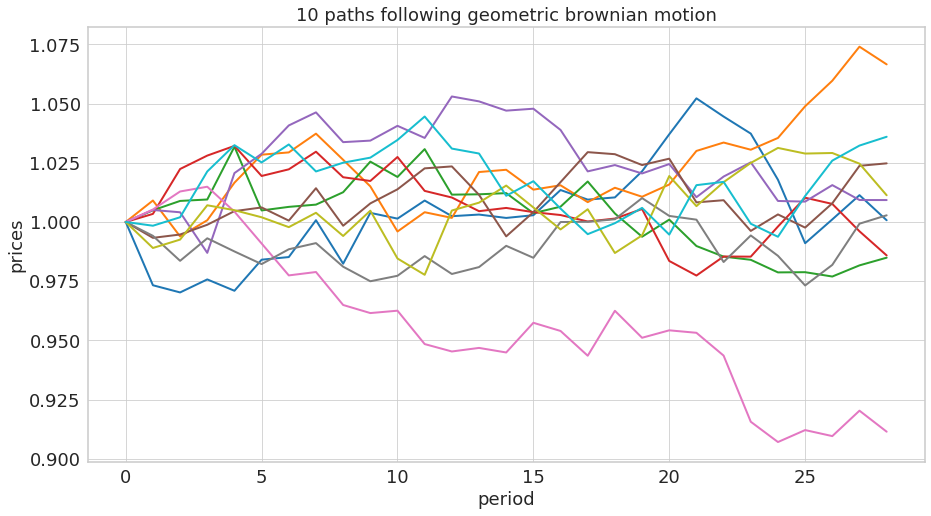

In [ ]:
# Plot 10 paths following geometric brownian motion
plt.figure(figsize=(15, 8))
plt.title('10 paths following geometric brownian motion')
plt.plot(to_numpy(gbm))
plt.xlabel('period')
plt.ylabel('prices')
plt.show()

In [ ]:
def european_option_delta(log_price, time_expiry, volatility):
    """
    :param log_price: log prices of the underlying asset - torch.Tensor
    :param time_expiry: Time to the expiry of the European option - torch.Tensor
    :param volatility: Volatility of the underlying asset - torch.Tensor
    :return delta : Black-Scholes' deta of a European option - torch.Tensor

    """

    s, t, v = map(torch.as_tensor, (log_price, time_expiry, volatility))
    normal = Normal(torch.tensor(0.0), torch.tensor(1.0))

    return normal.cdf((s + (v ** 2 / 2) * t) / (v * torch.sqrt(t)))

In [ ]:
# Example
european_option_delta([-0.01, 0.00, 0.01], 0.1, 0.2)

tensor([0.4497, 0.5126, 0.5752])

In [ ]:
def short_european_call_option_payoff(prices: torch.Tensor, strike=1.0, device='cpu'):
    """
    Return the payoff when short European option
    :param prices: Prices of underlying asset - torch.Tensor
    :return: payoff - torch.Tensor
    """

    return - F.relu(prices[-1, :] - strike)

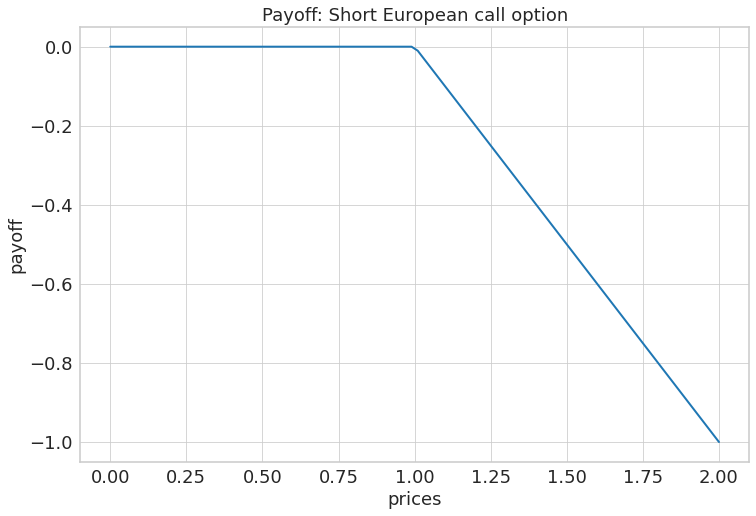

In [ ]:
# Example
# Payoff of call option
price = torch.linspace(0, 2, 100)  # The spot price at maturity
option_payoff = - F.relu(price - 1.0)

plt.figure(figsize=(12, 8))
plt.plot(to_numpy(price), to_numpy((option_payoff)))
plt.xlabel('prices')
plt.ylabel('payoff')
plt.title('Payoff: Short European call option')
plt.show()

# 2. *Define a funtion for profit and loss*

In [ ]:
def compute_profit_and_loss(
        hedging_model: torch.nn.Module,
        payoff: typing.Callable[[torch.Tensor], torch.Tensor],
        cost: float,
        n_paths=50000,
        maturity=30 / 365,
        dt=1 / 365,
        volatility=0.2,
        device='cpu'
):
    """
    Return profit and loss distribution after hedging

    :param hedging_model: Hedging model to fit - torch.nn.Module
    :param payoff: Payoff function of the derivative to hedge - callable[[torch.Tensor], torch.Tensor]
    :param cost: Transaction cost of underlying asset - float
    :return: profit and loss - float
    :param n_paths: Number of price paths - int
    :param maturity: Length of simulated period - float
    :param dt: Interval of time steps - float
    :param volatility: Volatility of asset price - float
    :param device: cpu or gpu
    """

    # Prepare time-series of prices with shape (time, bath)
    prices = generate_geometric_brownian_motion(n_paths, maturity=maturity, dt=dt, volatility=volatility, device=device)

    hedge = torch.zeros_like(prices[:1]).reshape(-1)  # shape: (1, n_paths)
    pnl = 0

    # Simulate hedging over time
    for n in range(prices.shape[0] - 1):
        # Prepare a model input
        x_log_prices = prices[n].unsqueeze(1).log()
        x_time_expiry = torch.full_like(x_log_prices, maturity - n * dt)
        x_volatility = torch.full_like(x_log_prices, volatility)
        x = torch.cat([x_log_prices, x_time_expiry, x_volatility], 1)

        # Infer a preferable hedge ratio
        prev_hedge = hedge
        hedge = hedging_model(x, prev_hedge)

        # Receive profit/loss from the original asset
        pnl += hedge * (prices[n + 1] - prices[n])
        # Pay transaction cost
        pnl -= cost * torch.abs(hedge - prev_hedge) * prices[n]

    # Pay the option's payoff to the customer
    pnl += payoff(prices)

    return pnl

#*3. Create hedging model*

In [ ]:
class MultilayerPerceptron(nn.Module):
    """
    Feed-forward neural network

    :param
    - in_features : number of input features - int
    - out_features : number of output features - int
    - n_layers : number of hidden layer - int
    - n_units : number of units in each hidden layer - int
    """

    def __init__(self, in_features, out_features, n_layer=4, n_units=32):
        super(MultilayerPerceptron, self).__init__()

        layer = []
        for i in range(n_layer):
            n = in_features if i == 0 else n_units
            layer.append(nn.Linear(n, n_units))
            layer.append(nn.ReLU())
        layer.append(nn.Linear(n_units, out_features))

        self.fc = nn.Sequential(*layer)

    def forward(self, x):
        return self.fc(x)

In [ ]:
class FeedForwardNet(nn.Module):
    def __init__(self, in_features=3):
        super(FeedForwardNet, self).__init__()

        self.mlp = MultilayerPerceptron(in_features + 1, 1)

    def forward(self, x, prev):
        # Black-Scholes' delta in the absence of transaction cost
        no_cost_delta = european_option_delta(x[:, 0], x[:, 1], x[:, 2])

        # Multi-layer perceptron directly computes the hedge ratio at the next time step
        x = torch.cat((x, prev.reshape(-1, 1)), 1)
        x = self.mlp(x).reshape(-1)
        x = torch.tanh(x)
        hedge = no_cost_delta + x

        return hedge

In [ ]:
hedging_model_feedforward_net = FeedForwardNet().to(device)
print(hedging_model_feedforward_net)

FeedForwardNet(
  (mlp): MultilayerPerceptron(
    (fc): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): ReLU()
      (8): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)


#*4. Compute profit and loss before training*

In [ ]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 500
# Volatility of stock price
volatility = 0.2

In [ ]:
torch.manual_seed(10)
pnl_before_train = compute_profit_and_loss(hedging_model_feedforward_net, short_european_call_option_payoff, n_paths=N_PATHS, cost=1e-3, volatility=volatility, device=device)

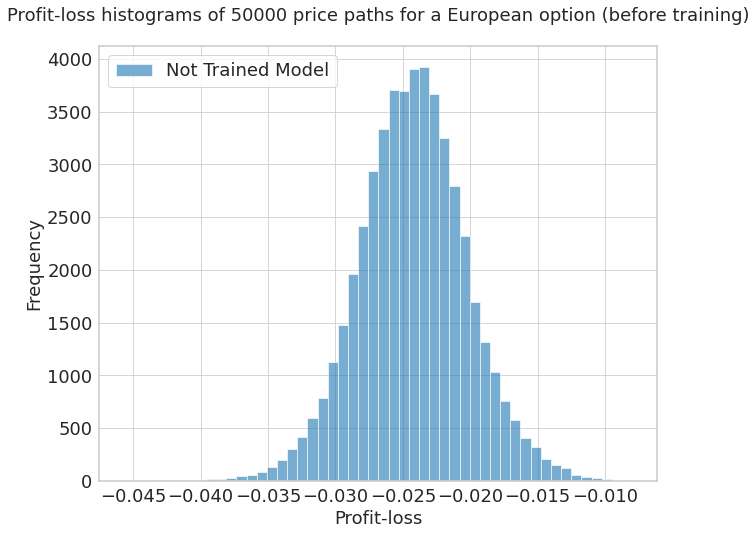

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(
    to_numpy(pnl_before_train),
    bins=50,
    alpha=0.6,
    label="Not Trained Model",
)
plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (before training)", pad=25
)
plt.xlabel("Profit-loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#*5. Train hedging model*

In [ ]:
def train_with_entropic_loss(
        hedging_model: torch.nn.Module,
        payoff: typing.Callable[[torch.Tensor], torch.tensor],
        cost: float,
        volatility=0.2,
        n_epochs=100,
        device='cpu'
):
    """
    Fit a hedging model to hedge the given derivative

    :param hedging_model: Hedging model to fit - torch.nn.Module
    :param payoff: Payoff function of the derivative to hedge - callable[[torch.Tensor], torch.Tensor]
    :param cost: Transaction cost - float
    :param n_epochs: Times a hedging model is updated in the experiment
    :return loss history: History of training loss
    :param device: cpu or cuda
    """

    optim = torch.optim.Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(n_epochs))

    for _ in progress:
        optim.zero_grad()
        pnl = compute_profit_and_loss(hedging_model, payoff, cost, volatility=volatility, device=device)
        loss = entropic_loss(pnl)
        loss.backward()
        optim.step()

        progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())

    return loss_history

In [ ]:
loss_history_with_entropic_loss = train_with_entropic_loss(hedging_model_feedforward_net, short_european_call_option_payoff, volatility=volatility, n_epochs=N_EPOCHS, cost=1e-3, device=device)

Loss=0.02279: 100%|██████████| 500/500 [00:31<00:00, 15.86it/s]


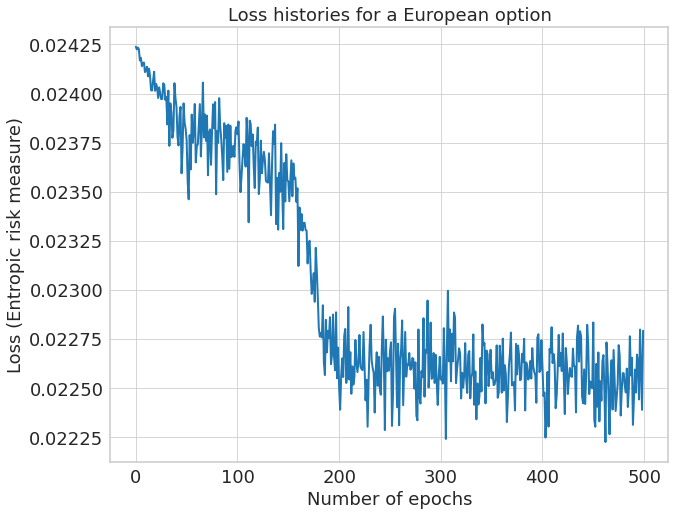

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(loss_history_with_entropic_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Entropic risk measure)")
plt.title("Loss histories for a European option")
# plt.legend()
plt.show()

# *6. Compute profit and loss after training*

In [ ]:
pnl_after_train_with_entropic_loss = compute_profit_and_loss(hedging_model_feedforward_net, short_european_call_option_payoff, cost=1e-3, volatility=volatility, device=device)

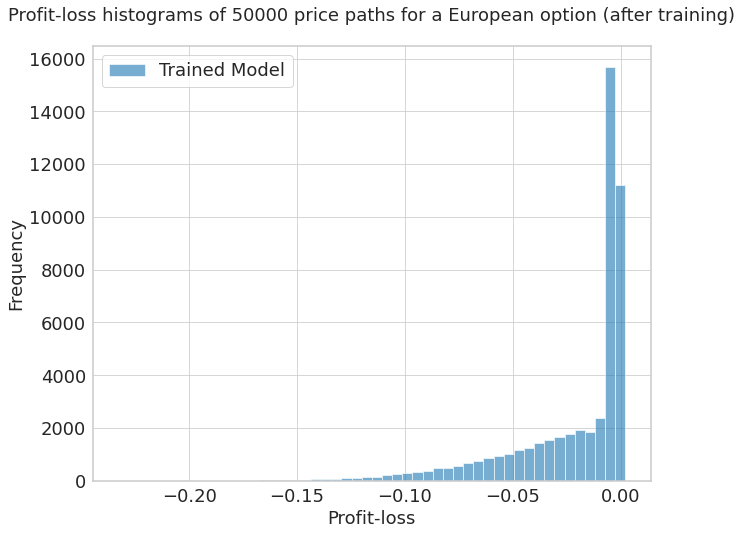

In [ ]:
plt.figure(figsize=(10, 8))

plt.hist(
    to_numpy(pnl_after_train_with_entropic_loss),
    bins=50,
    alpha=0.6,
    label="Trained Model",
)

plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (after training)", pad=25
)
plt.xlabel("Profit-loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# *7. Compare profit and loss before/after training*

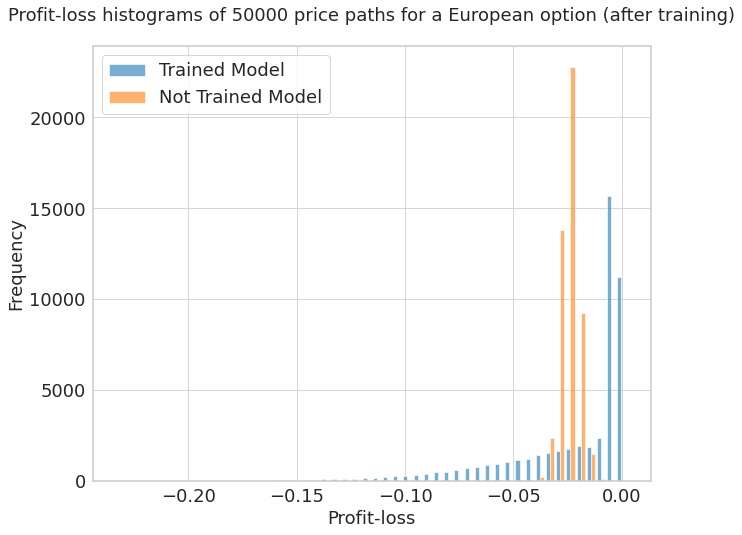

In [ ]:
plt.figure(figsize=(10, 8))

plt.hist(
    [to_numpy(pnl_after_train_with_entropic_loss), to_numpy(pnl_before_train)],
    bins=50,
    alpha=0.6,
    label=["Trained Model", "Not Trained Model"],    
)

plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (after training)", pad=25
)
plt.xlabel("Profit-loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# **Assignment**

#*8. Train hedging model using PnL as objective*

In [ ]:
def train_with_pnl(
        hedging_model: torch.nn.Module,
        payoff: typing.Callable[[torch.Tensor], torch.tensor],
        cost: float,
        volatility=0.2,
        n_epochs=100,
        n_paths=50000,
        device='cpu'
):
    """
    Fit a hedging model to hedge the given derivative

    :param hedging_model: Hedging model to fit - torch.nn.Module
    :param payoff: Payoff function of the derivative to hedge - callable[[torch.Tensor], torch.Tensor]
    :param cost: Transaction cost - float
    :param n_epochs: Times a hedging model is updated in the experiment
    :return loss history: History of training loss
    :param device: cpu or cuda
    """

    optim = torch.optim.Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(n_epochs))

    for _ in progress:
        optim.zero_grad()
        pnl = compute_profit_and_loss(hedging_model, payoff, cost, volatility=volatility, device=device)
        # Fill in the code
        # If we want to maximize PnL, what is the loss function? 
        # Hint 1: Maximize PnL = Minimize(-PnL)
        # Hint 2: optim.step(): update parameters to minimize loss function
        #########################################################
        loss = min(-pnl)
        #########################################################
        loss.backward()
        optim.step()

        progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())

    return loss_history

In [ ]:
hedging_model_with_pnl = FeedForwardNet().to(device)

In [ ]:
loss_history_with_pnl = train_with_pnl(hedging_model_with_pnl, short_european_call_option_payoff, n_epochs=N_EPOCHS, cost=1e-3, volatility=volatility, device=device)

Loss=-0.18726: 100%|██████████| 500/500 [13:08<00:00,  1.58s/it]


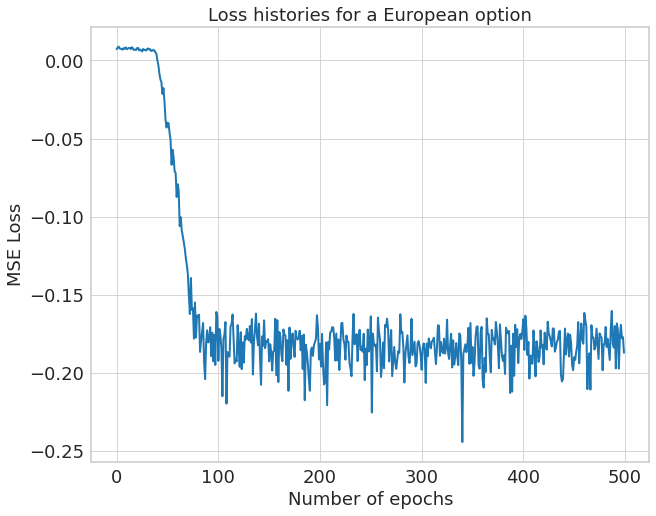

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(loss_history_with_pnl)
plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title("Loss histories for a European option")
plt.show()

# *9. Plot PnL after training using PnL*

In [ ]:
pnl_after_train_with_pnl = compute_profit_and_loss(hedging_model_with_pnl, short_european_call_option_payoff, cost=1e-3, volatility=volatility, device=device)

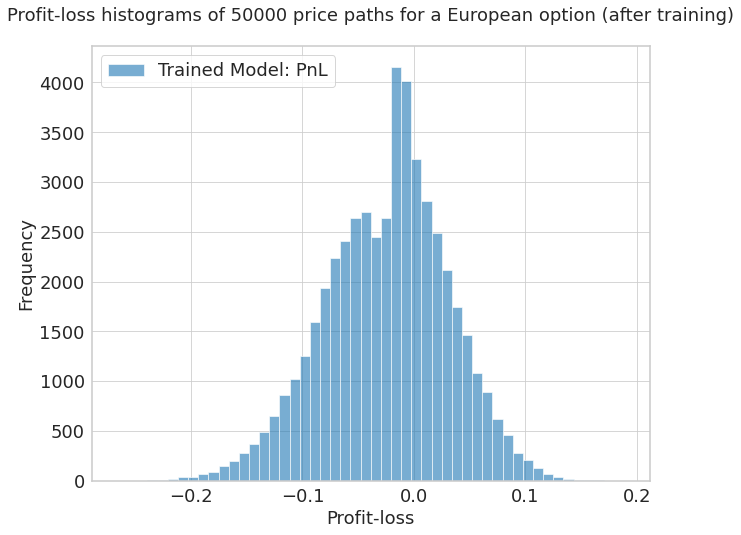

In [ ]:
plt.figure(figsize=(10, 8))

plt.hist(
    to_numpy(pnl_after_train_with_pnl),
    bins=50,
    alpha=0.6,
    label="Trained Model: PnL",
)

plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (after training)", pad=25
)
plt.xlabel("Profit-loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#*10. Compare the training results*

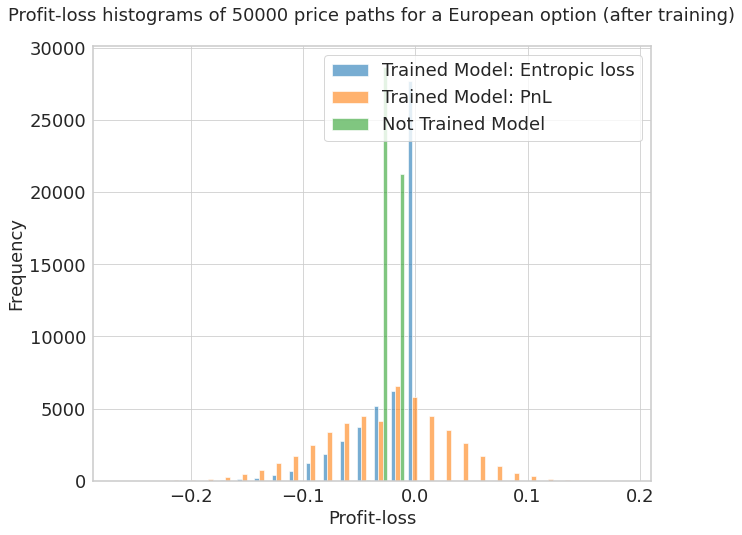

In [ ]:
plt.figure(figsize=(10, 8))

plt.hist(
    [to_numpy(pnl_after_train_with_entropic_loss), to_numpy(pnl_after_train_with_pnl), to_numpy(pnl_before_train)],
    bins=30,
    alpha=0.6,
    label=["Trained Model: Entropic loss", "Trained Model: PnL", "Not Trained Model"],    
)

plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (after training)", pad=25
)
plt.xlabel("Profit-loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()